**Chapter 6 – Natural Language Processing**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/hanchen92/handson-ml3/blob/main/06_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/hanchen92/handson-ml3/main/06_NLP.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

In [30]:
!wget -O Tweets.csv "https://raw.githubusercontent.com/hanchen92/THU-STAT-BigData-113-1-6189/refs/heads/main/datasets/Tweets.csv"

--2024-10-20 13:44:27--  https://raw.githubusercontent.com/hanchen92/THU-STAT-BigData-113-1-6189/refs/heads/main/datasets/Tweets.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/plain]
Saving to: ‘Tweets.csv’

Tweets.csv          100%[===================>]   3.26M  --.-KB/s    in 0.06s   

2024-10-20 13:44:28 (59.0 MB/s) - ‘Tweets.csv’ saved [3421431/3421431]



In [31]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns



# 改style要在改font之前
# plt.style.use('seaborn')

mpl.rcParams['figure.figsize'] = 12,5

# Data Introduction
- The data was collected from Twitter in February 2015, focusing on comments about various U.S. airlines in Twitter. (https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)
- The sentiment of the comments has been categorized into three types: negative, neutral, and positive.
- The main columns of the data are:
    1. airline_sentiment: The labeled sentiment of the comment.
    2. airline: The airline mentioned in the comment.
    3. text: The content of the comment.
- Goal: Develop a method or model to predict the sentiment of future comments (to reduce labor costs).


# Read data

In [32]:
airline_data = pd.read_csv("/content/Tweets.csv")


# First of all let's drop the columns which we don't required
waste_col = ['airline_sentiment_confidence',
             'negativereason_confidence',
             'airline_sentiment_gold',
             'name',
             'negativereason_gold',
             'retweet_count',
             'tweet_coord',
             'tweet_created',
             'tweet_location',
             'user_timezone']

data = airline_data.drop(waste_col, axis = 1)
data.head()

,tweet_id,airline_sentiment,negativereason,airline,text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...


# EDA
### Bar plot showing the count and probability of sentiments in the comments



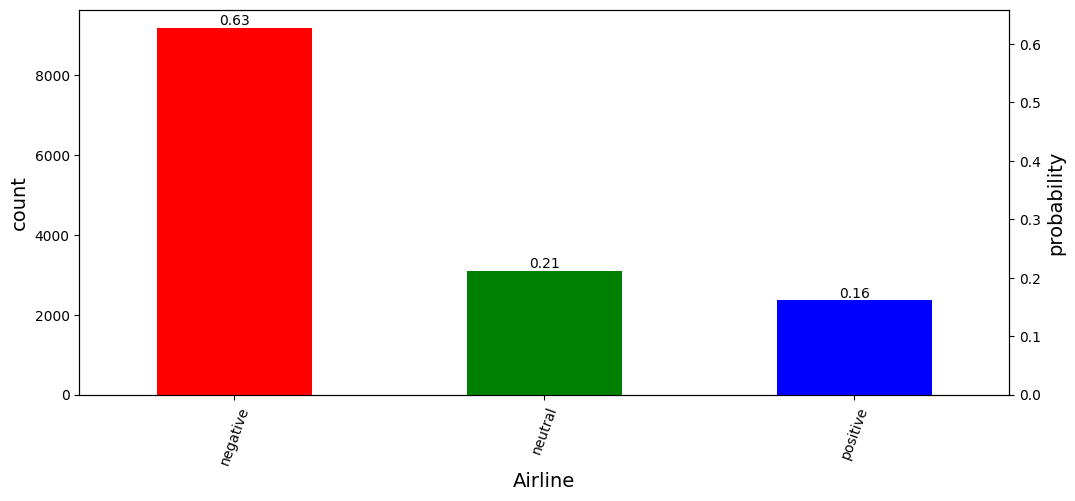

In [33]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
tmp_count = airline_data["airline_sentiment"].value_counts()
tmp_count.plot(kind = 'bar', color=['red', 'green', 'blue'], rot = 70)
# set x-axis label
ax.set_xlabel("Airline",fontsize=14)
# set y-axis label
ax.set_ylabel("count",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
(tmp_count/np.sum(tmp_count)).plot(kind = 'bar', color=['red', 'green', 'blue'], rot = 70)
ax2.bar_label(ax2.containers[0], fmt='%.2f')
ax2.set_xlabel("Airline",fontsize=14)
ax2.set_ylabel("probability",fontsize=14)
plt.show()

# save the plot as a file
fig.savefig('sentiment_barplot.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

### Bar plot showing the count and probability of the airline companies

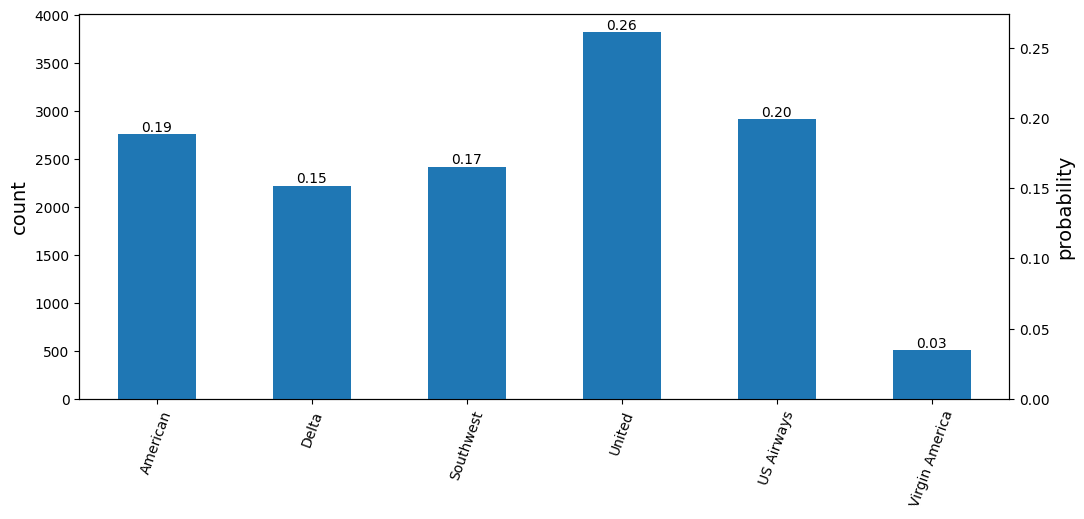

In [34]:
sort_comp = ['American','Delta','Southwest','United','US Airways','Virgin America']

# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
tmp_count = airline_data["airline"].value_counts().loc[sort_comp]
(tmp_count).plot(kind = 'bar', rot = 70)
# set x-axis label
ax.set_xlabel("",fontsize=14)
# set y-axis label
ax.set_ylabel("count",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
tmp_count = airline_data["airline"].value_counts().loc[sort_comp]
(tmp_count/np.sum(tmp_count)).plot(kind = 'bar', rot = 70)
ax2.bar_label(ax2.containers[0], fmt='%.2f')

#(tmp_count/np.sum(tmp_count)).plot(kind = 'bar', color=['red', 'green', 'blue'], figsize = (7,3), rot = 70)
ax2.set_ylabel("probability",fontsize=14)
plt.show()
ax2.set_xlabel("Airline",fontsize=14)

# save the plot as a file
fig.savefig('ariline_barplot.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

### Bar plot showing the distribution and probability of sentiments across airline companies

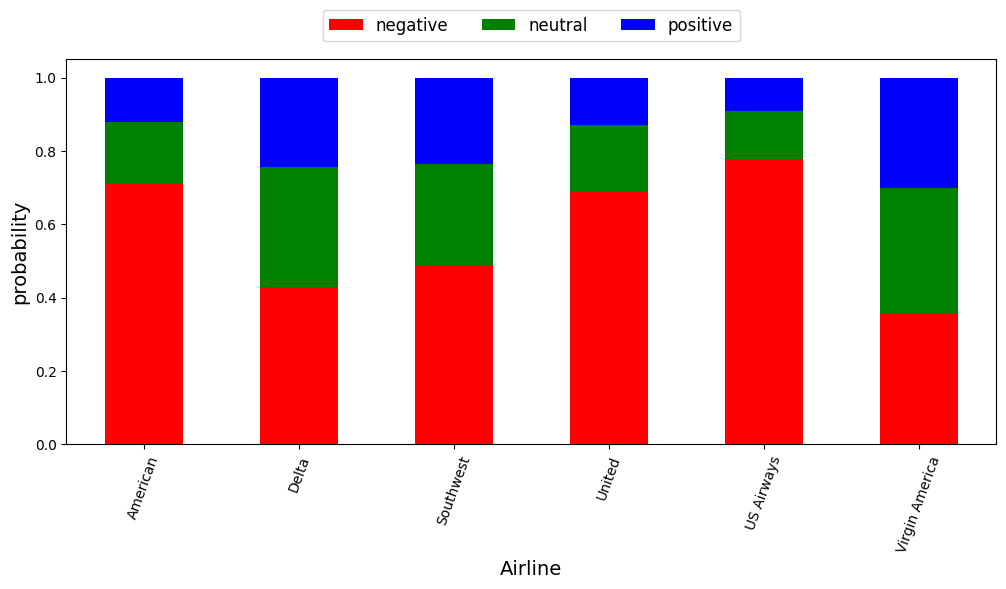

In [35]:
airline_data2 = airline_data.groupby(["airline","airline_sentiment"])["airline_sentiment"].count().reset_index(name='count')
airline_data3 = airline_data2.pivot_table(index='airline', values='count', columns = 'airline_sentiment').apply(lambda x: x/np.sum(x),axis=1)

ax = airline_data3.loc[sort_comp,:].plot(kind = 'bar', stacked=True, color=['red', 'green', 'blue','yellow','purple','orange'], rot = 70)

ax.set_ylabel("probability",fontsize=14)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, prop={'size': 12})
ax.set_xlabel("Airline",fontsize=14)

ax.figure.savefig('ariline_sentiment_barplot.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

### Bar plot showing the distribution of negative reasons across airline companies




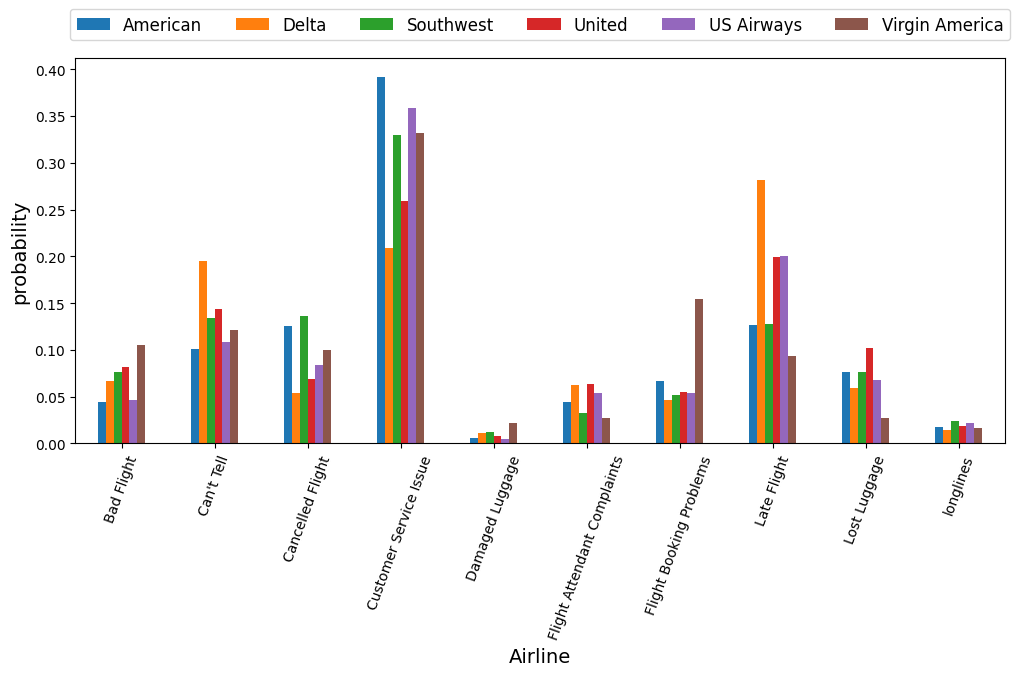

In [36]:
airline_data2 = airline_data.groupby(["airline","negativereason"])["negativereason"].count().reset_index(name='count')
airline_data3 = airline_data2.pivot_table(index='airline', values='count', columns = 'negativereason').apply(lambda x: x/np.sum(x), axis = 1)

ax = airline_data3.loc[sort_comp,:].T.plot(kind = 'bar', rot = 70)

ax.set_ylabel("probability",fontsize=14)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=6, prop={'size': 12})
ax.set_xlabel("Airline",fontsize=14)

ax.figure.savefig('ariline_negetive_barplot.png',
            format='png',
            dpi=100,
            bbox_inches='tight')

### Bar plot showing the probability of negative tweets for each day across airline companies



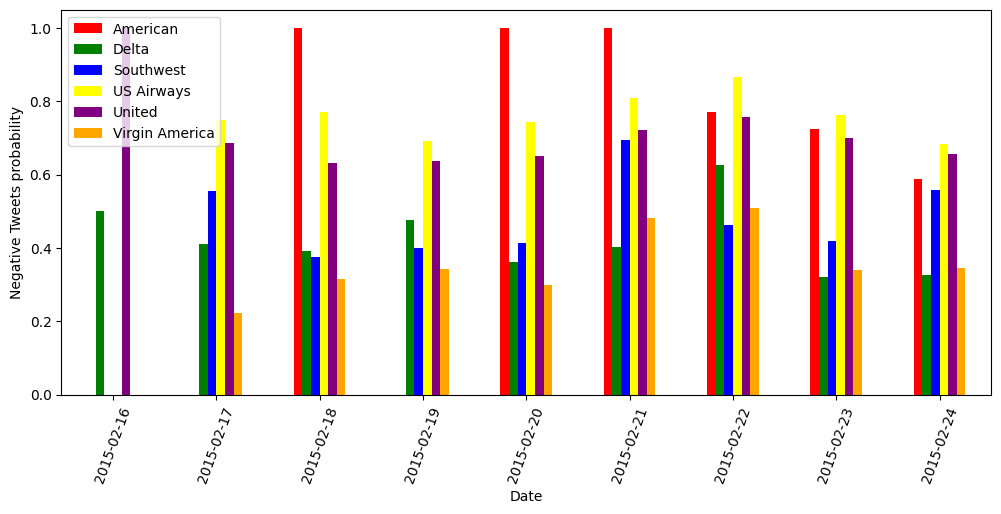

In [37]:
date = airline_data.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date["tweet_created_date"] = date.tweet_created.dt.date

tmp_date = date.copy()
tmp_date2 = tmp_date.groupby(['tweet_created_date','airline','airline_sentiment'])['airline_sentiment'].count().reset_index(name="count")
#day_df2 = day_df.groupby(['tweet_created_date','airline']).apply(lambda x: x/np.sum(x))

tmp_date3 = tmp_date2.pivot_table(index=['tweet_created_date','airline'], columns='airline_sentiment', values='count', fill_value=0).apply(lambda x:  x/np.sum(x), axis = 1)

tmp_date4 = tmp_date3.loc[:,'negative']

#groupby and plot data
ax2 = tmp_date4.groupby(['tweet_created_date','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets probability')
plt.show()

### Bar plot showing the probability of negative reasons for each day in the American airline company



<ipython-input-38-587370622057>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_date.tweet_created = pd.to_datetime(tmp_date.tweet_created)
<ipython-input-38-587370622057>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_date.tweet_created = tmp_date.tweet_created.dt.date


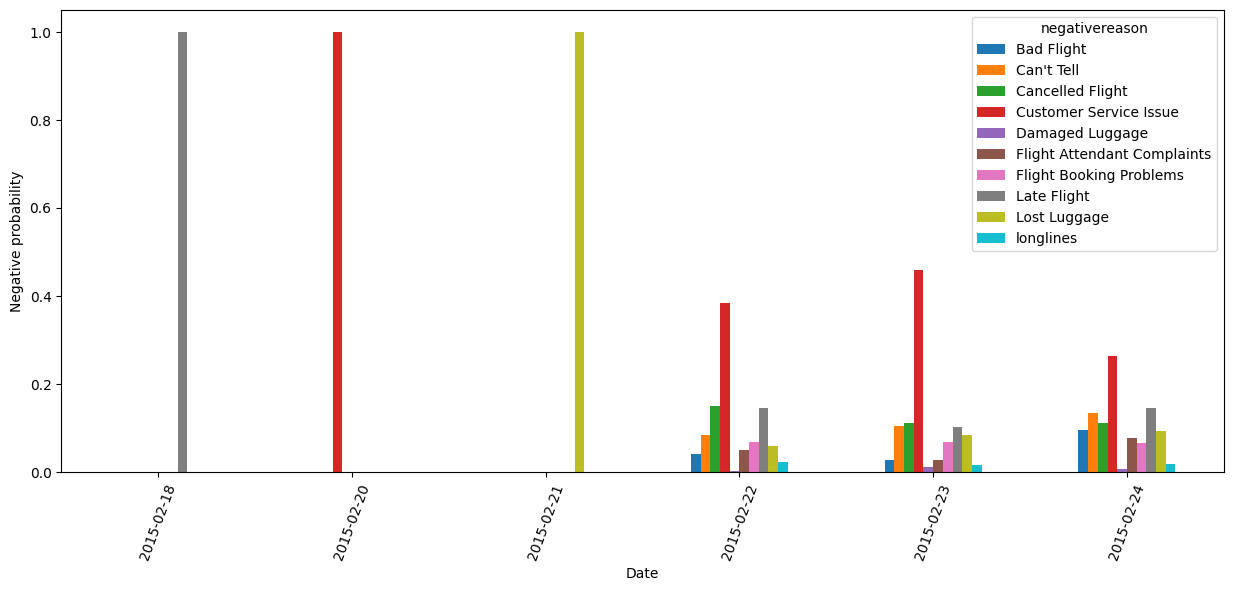

In [38]:
#date_org = airline_data.reset_index()
tmp_date = date.loc[date["airline"]=="American",:]
#convert the Date column to pandas datetime
tmp_date.tweet_created = pd.to_datetime(tmp_date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
tmp_date.tweet_created = tmp_date.tweet_created.dt.date


tmp_date2 = tmp_date.groupby(['tweet_created','negativereason'])['negativereason'].count().reset_index(name = 'count')
tmp_date3 = tmp_date2.pivot_table(index = 'tweet_created', values = 'count', columns = 'negativereason').apply(lambda x:  x/np.sum(x), axis = 1)


#groupby and plot data
ax2 = tmp_date3.plot(kind = 'bar', figsize = (15,6), rot = 70)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative probability')
plt.show()

### Check the comments for the American airline company on 2015.02.20

In [39]:
import datetime

In [40]:
airline_data_check = airline_data.loc[airline_data["airline"]=="American",["tweet_id","tweet_created","text"]]

airline_data_check.tweet_created = pd.to_datetime(airline_data_check.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
airline_data_check.tweet_created = airline_data_check.tweet_created.dt.date

airline_data_check.loc[airline_data_check["tweet_created"]==datetime.date(2015,2,20),:]

,tweet_id,tweet_created,text
12035,568824537338417154,2015-02-20,@AmericanAir - how long does it take to get cr...


# Data Preprocessing

In [41]:
# def sentiment(x):
#     if x == 'positive':
#         return 1
#     elif x == 'negative':
#         return -1
#     else:
#         return 0

### 1. Text Lowercase

In [42]:
tmp_text = "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo"
tmp_text.lower()

"@virginamerica so excited for my first cross country flight lax to mco i've heard nothing but great things about virgin america. #29daystogo"

### 2. Expand contractions

In [43]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re

contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# Usage
replace_contractions(tmp_text)

'@VirginAmerica So excited for my first cross country flight LAX to MCO I have heard nothing but great things about Virgin America. #29DaysToGo'

### 3. Remove uninformative words, digits and default stopwords

In [44]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

def tmp_remove_stopwords(sentence):
    sentence = sentence.lower()
    sentence = replace_contractions(sentence)
    sentence = re.sub(r"(@\w*)|(\S*\d\S*)", "", sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = ' '.join([tmp_word for tmp_word in sentence.split() if tmp_word not in stopwords_list])
    return(sentence)


tmp_remove_stopwords(tmp_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'excited first cross country flight lax mco heard nothing great things virgin america'

### 4. Stemming and Lemmatization


In [45]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def tmp_stem_sentence(sentence):
    sentence = sentence.lower()
    sentence = replace_contractions(sentence)
    sentence = re.sub(r"(@\w*)|(\S*\d\S*)", "", sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = ' '.join([tmp_word for tmp_word in sentence.split() if tmp_word not in stopwords_list])
    sentence = ' '.join([stemmer.stem(tmp_word) for tmp_word in sentence.split()])
    return(sentence)

tmp_stem_sentence(tmp_text)

'excit first cross countri flight lax mco heard noth great thing virgin america'

In [46]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag


lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tmp_lemm_sentence(sentence):
    sentence = sentence.lower()
    sentence = replace_contractions(sentence)
    sentence = re.sub(r"(@\w*)|(\S*\d\S*)", "", sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = sentence.split()#" ".join([tmp_word for tmp_word in sentence.split() if tmp_word not in stopwords_list])
    pos_tags = pos_tag(sentence)
    sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    #sentence = [tmp_word for tmp_word in sentence if tmp_word not in stopwords_list]
    lemmatized_sentence = ' '.join(sentence)
    return lemmatized_sentence


tmp_lemm_sentence(tmp_text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


'so excited for my first cross country flight lax to mco i have hear nothing but great thing about virgin america'

5. Tokenizer

In [47]:
from nltk.tokenize import RegexpTokenizer

#tmp_pattern = r"(?x)([A-Z]\.)+|\$?\d+(\.\d+)?%?|\w+([-']\w+)*|[+/\-@&*]"

tokenizer = RegexpTokenizer(r"[\w']+")
# As this dataset is fetched from twitter so it has lots of people tag in tweets
# we will remove them
#tags = r"(@\w*)|(\S*\d\S*)"

# Fianl perprocessing function
def preprocess_text(sentence, stem = True):

    sentence = sentence.lower()
    sentence = replace_contractions(sentence)
    sentence = re.sub(r"(@\w*)|(\S*\d\S*)", "", sentence)
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    sentence = ' '.join([tmp_word for tmp_word in sentence.split() if tmp_word not in stopwords_list])

    if stem:
        sentence = ' '.join([stemmer.stem(tmp_word) for tmp_word in sentence.split()])

    text=tokenizer.tokenize(sentence)

    return text

preprocess_text(tmp_text)

['excit',
 'first',
 'cross',
 'countri',
 'flight',
 'lax',
 'mco',
 'heard',
 'noth',
 'great',
 'thing',
 'virgin',
 'america']

In [48]:
tmp_text = "@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo"
print(tmp_text)
tmp_text2 = tmp_text.lower()
print(tmp_text2)
tmp_text3 = replace_contractions(tmp_text2)
print(tmp_text3)
tmp_text4 = re.sub(r"(@\w*)|(\S*\d\S*)", "", tmp_text3)
print(tmp_text4)
tmp_text5 = sentence = re.sub(r'[^\w\s]',' ',tmp_text4)
print(tmp_text5)
tmp_text6 = ' '.join([tmp_word for tmp_word in tmp_text5.split() if tmp_word not in stopwords_list])
print(tmp_text6)
tmp_text7 = ' '.join([stemmer.stem(tmp_word) for tmp_word in tmp_text6.split()])
print(tmp_text7)
tmp_text8=tokenizer.tokenize(tmp_text7)
print(tmp_text8)

#stemmer.stem(word).lower()

@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo
@virginamerica so excited for my first cross country flight lax to mco i've heard nothing but great things about virgin america. #29daystogo
@virginamerica so excited for my first cross country flight lax to mco i have heard nothing but great things about virgin america. #29daystogo
 so excited for my first cross country flight lax to mco i have heard nothing but great things about virgin america. 
 so excited for my first cross country flight lax to mco i have heard nothing but great things about virgin america  
excited first cross country flight lax mco heard nothing great things virgin america
excit first cross countri flight lax mco heard noth great thing virgin america
['excit', 'first', 'cross', 'countri', 'flight', 'lax', 'mco', 'heard', 'noth', 'great', 'thing', 'virgin', 'america']


In [49]:
data["new_text"] = data.text.map(preprocess_text)
data.head()

,tweet_id,airline_sentiment,negativereason,airline,text,new_text
0,570306133677760513,neutral,NaN,Virgin America,@VirginAmerica What @dhepburn said.,[said]
1,570301130888122368,positive,NaN,Virgin America,@VirginAmerica plus you've added commercials t...,"[plus, ad, commerci, experi, tacki]"
2,570301083672813571,neutral,NaN,Virgin America,@VirginAmerica I didn't today... Must mean I n...,"[today, must, mean, need, take, anoth, trip]"
3,570301031407624196,negative,Bad Flight,Virgin America,@VirginAmerica it's really aggressive to blast...,"[realli, aggress, blast, obnoxi, entertain, gu..."
4,570300817074462722,negative,Can't Tell,Virgin America,@VirginAmerica and it's a really big bad thing...,"[realli, big, bad, thing]"


In [50]:
def word_transform(data):
    n = data.shape[0]
    data_word_list = []
    for i in range(n):
        tmp_data = data.iloc[i,:]
        for word in tmp_data["new_text"]:
            data_word_list.append([tmp_data["tweet_id"] ,tmp_data["airline_sentiment"], tmp_data["airline"], word])

    data_word = pd.DataFrame(data_word_list, columns =['tweet_id' ,'airline_sentiment', 'airline', 'word'])

    return data_word

In [51]:
data_word = word_transform(data)

In [52]:
data_word_count = data_word.drop_duplicates().groupby(["airline_sentiment","word"])["word"].count().reset_index(name='count')
data_word_count2 = data_word_count.pivot_table(index='word', columns='airline_sentiment', values='count',fill_value=0)

In [53]:
data_word_count2["n"] = data_word_count2["positive"] + data_word_count2["negative"]
data_word_count2["positive_p"] = data_word_count2["positive"]/(data_word_count2["n"])
data_word_count2["Z_statistics"] = (data_word_count2["positive_p"]-0.2)/np.sqrt(0.2*0.8/data_word_count2["n"])

In [54]:
from wordcloud import WordCloud,STOPWORDS

airline_sentiment     word  negative  neutral  positive       n  positive_p  \
131                  thank     388.0    223.0    1029.0  1417.0    0.726182   
59                   great      79.0     18.0     218.0   297.0    0.734007   
84                    love      77.0     52.0     159.0   236.0    0.673729   
8                   awesom      18.0      6.0      97.0   115.0    0.843478   
1                     amaz      16.0      6.0      82.0    98.0    0.836735   
12                    best      63.0     23.0     104.0   167.0    0.622754   
4                  appreci      61.0     16.0      84.0   145.0    0.579310   
89                    much      93.0     26.0     103.0   196.0    0.525510   
114                   rock       6.0      4.0      37.0    43.0    0.860465   
82                    kudo       3.0      1.0      26.0    29.0    0.896552   

airline_sentiment  Z_statistics  
131                   49.517759  
59                    23.007264  
84                    18.193

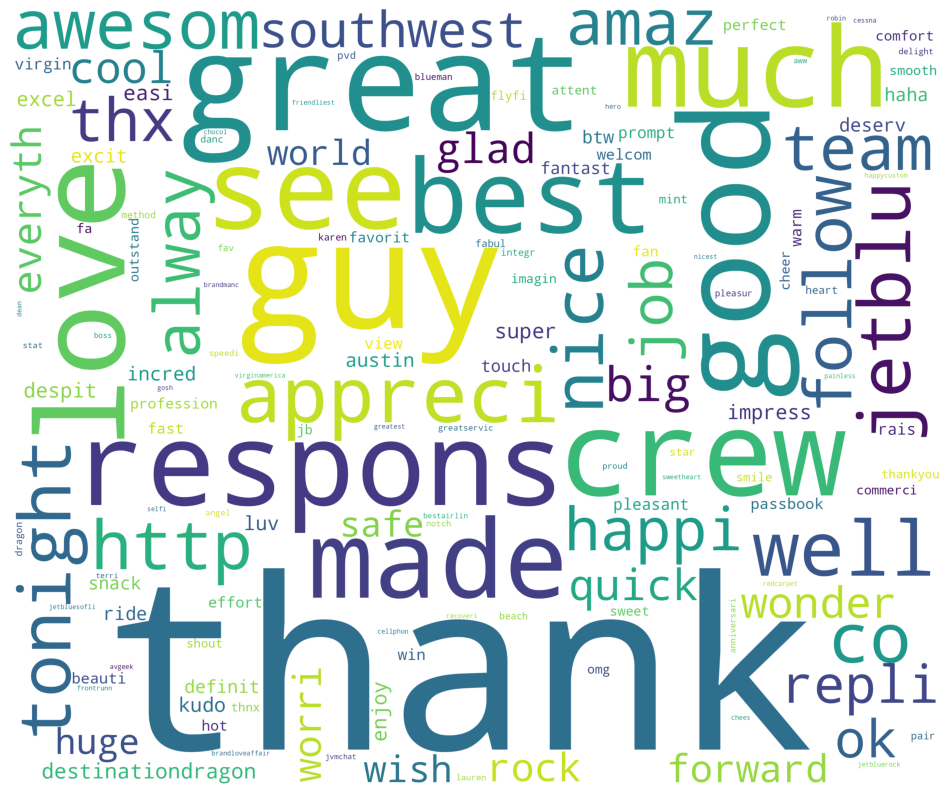

In [55]:
data_word_count2_positive = data_word_count2.loc[data_word_count2["Z_statistics"]>=3,:].reset_index()
data_word_count2_positive = data_word_count2_positive.loc[[tmp_word not in stopwords_list for tmp_word in data_word_count2_positive["word"]],:]
print(data_word_count2_positive.sort_values(by="Z_statistics", ascending=False, key=abs).iloc[0:10,:])
dict_positive = dict(zip(data_word_count2_positive["word"], data_word_count2_positive["n"]))
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(dict_positive)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

airline_sentiment     word  negative  neutral  positive       n  positive_p  \
65                    hour    1019.0     32.0      22.0  1041.0    0.021134   
19                  cancel     867.0     97.0      37.0   904.0    0.040929   
62                    hold     623.0     23.0       9.0   632.0    0.014241   
38                   delay     851.0     47.0      43.0   894.0    0.048098   
50                  flight    2805.0    696.0     393.0  3198.0    0.122889   
18                    call     615.0     50.0      33.0   648.0    0.050926   
51                 flightl     448.0     46.0      13.0   461.0    0.028200   
13                     bag     595.0     54.0      42.0   637.0    0.065934   
137                   wait     626.0     31.0      49.0   675.0    0.072593   
87                    need     459.0    177.0      24.0   483.0    0.049689   

airline_sentiment  Z_statistics  
65                   -14.427608  
19                   -11.956792  
62                   -11.674

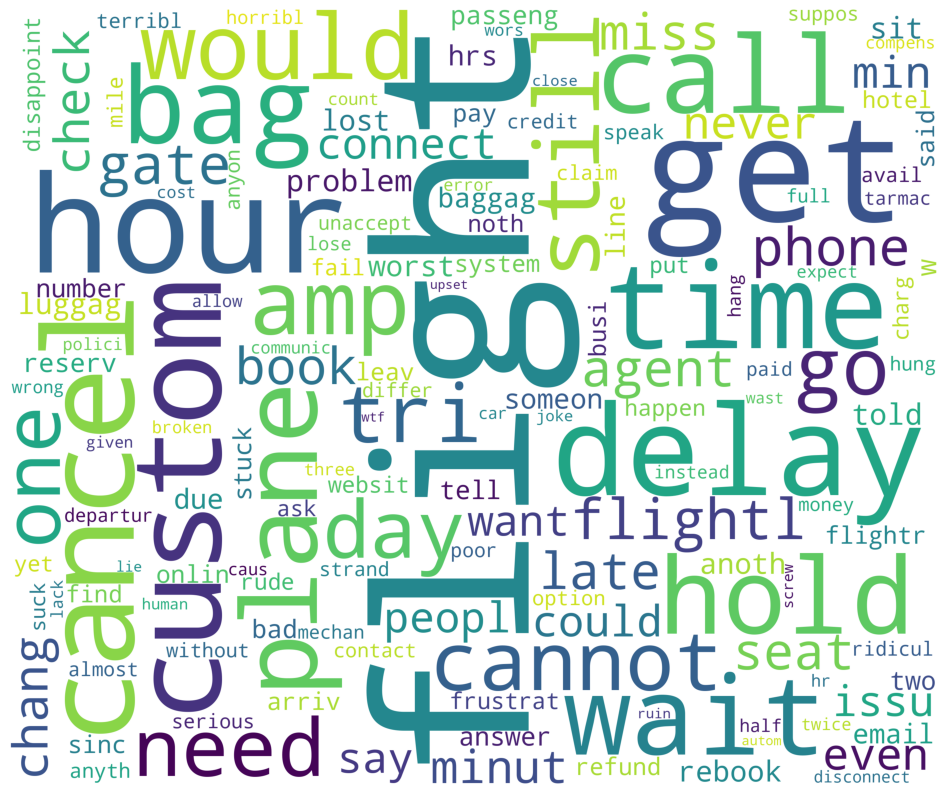

In [56]:
data_word_count2_negative = data_word_count2.loc[data_word_count2["Z_statistics"]<=-3,:].reset_index()
data_word_count2_negative = data_word_count2_negative.loc[[tmp_word not in stopwords_list for tmp_word in data_word_count2_negative["word"]],:]
print(data_word_count2_negative.sort_values(by="Z_statistics", ascending=False, key=abs).iloc[0:10,:])
dict_negative = dict(zip(data_word_count2_negative["word"], data_word_count2_negative["n"]))

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=3000,
                      height=2500
                     ).generate_from_frequencies(dict_negative)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [57]:
data['corpus'] = [' '.join(tmp_text) for tmp_text in data['new_text']]

train,test = train_test_split(data,test_size=0.3,random_state=42)


y_train = train["airline_sentiment"]
y_test = test["airline_sentiment"]

# Model Building


## VADER Sentiment Analysis

In [58]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00


In [59]:
data.iloc[5,:]
data.text[5]

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [60]:
analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores(data.text[5])

{'neg': 0.246, 'neu': 0.682, 'pos': 0.072, 'compound': -0.5945}

In [61]:
# import re


# emoji_pattern = re.compile("["
#         u"\U0001F600-\U0001F64F"  # emoticons
#         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
#         u"\U0001F680-\U0001F6FF"  # transport & map symbols
#         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
#                            "]+", flags=re.UNICODE)
# def emoji_remove(text_list):
#     return [emoji_pattern.sub(r'', tmp_text) for tmp_text in text_list]


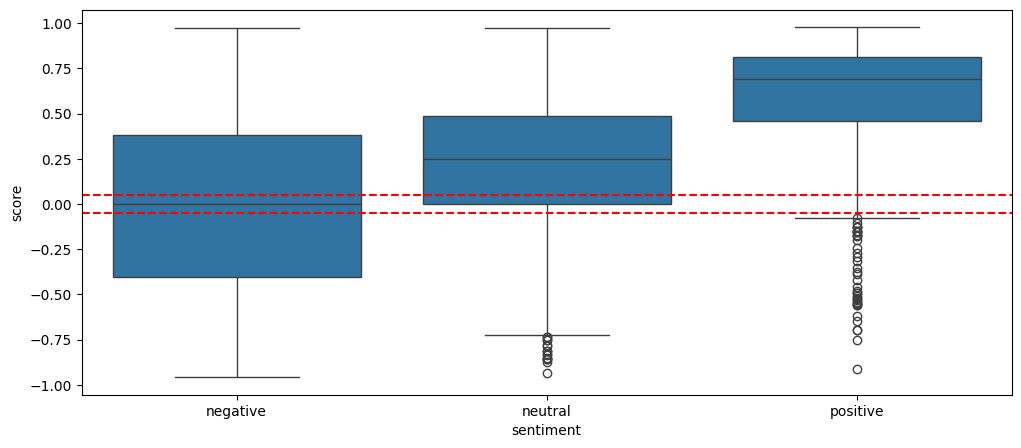

In [62]:
sentiment_score_train = [analyzer.polarity_scores(tmp_sentence)["compound"] for tmp_sentence in train['text']]
sentiment_score_test = [analyzer.polarity_scores(tmp_sentence)["compound"] for tmp_sentence in test['text']]

train_sentiment_data = pd.DataFrame({'score': sentiment_score_train, 'sentiment': y_train})
graph = sns.boxplot(x="sentiment", y="score", data=train_sentiment_data, order=["negative", "neutral", "positive"])

graph.axhline(0.05, linestyle= '--',color='red')
graph.axhline(-0.05, linestyle= '--',color='red')

plt.show()
graph.get_figure().savefig('vader_result.png')

[[1270  997  547]
 [ 114  509  261]
 [  26  124  544]]
              precision    recall  f1-score   support

    negative       0.45      0.90      0.60      1410
     neutral       0.58      0.31      0.40      1630
    positive       0.78      0.40      0.53      1352

    accuracy                           0.53      4392
   macro avg       0.60      0.54      0.51      4392
weighted avg       0.60      0.53      0.51      4392



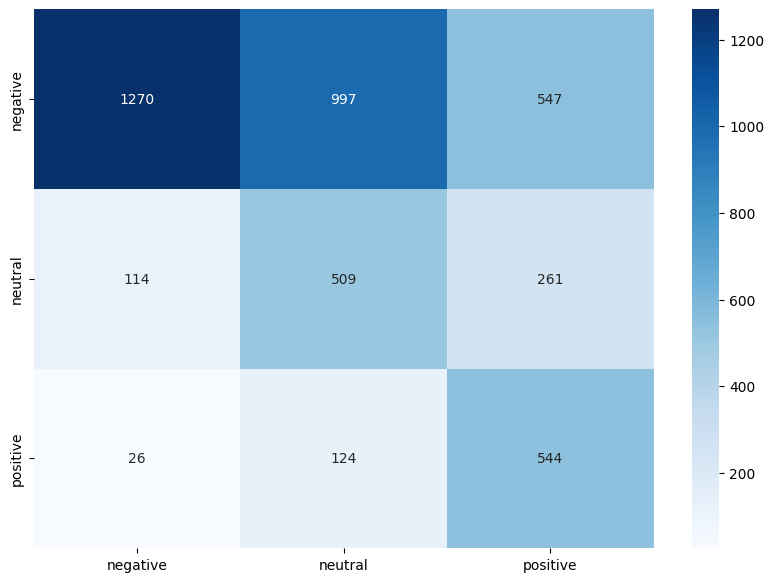

In [63]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(class_weight="balanced",max_depth=2)
data_sentiment_score_train=pd.DataFrame({"sentiment_score": sentiment_score_train})
clf = clf.fit(data_sentiment_score_train, y_train)

data_sentiment_score_test=pd.DataFrame({"sentiment_score": sentiment_score_test})
y_test_predict = clf.predict(data_sentiment_score_test)

print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))

df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_vader.png')

accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

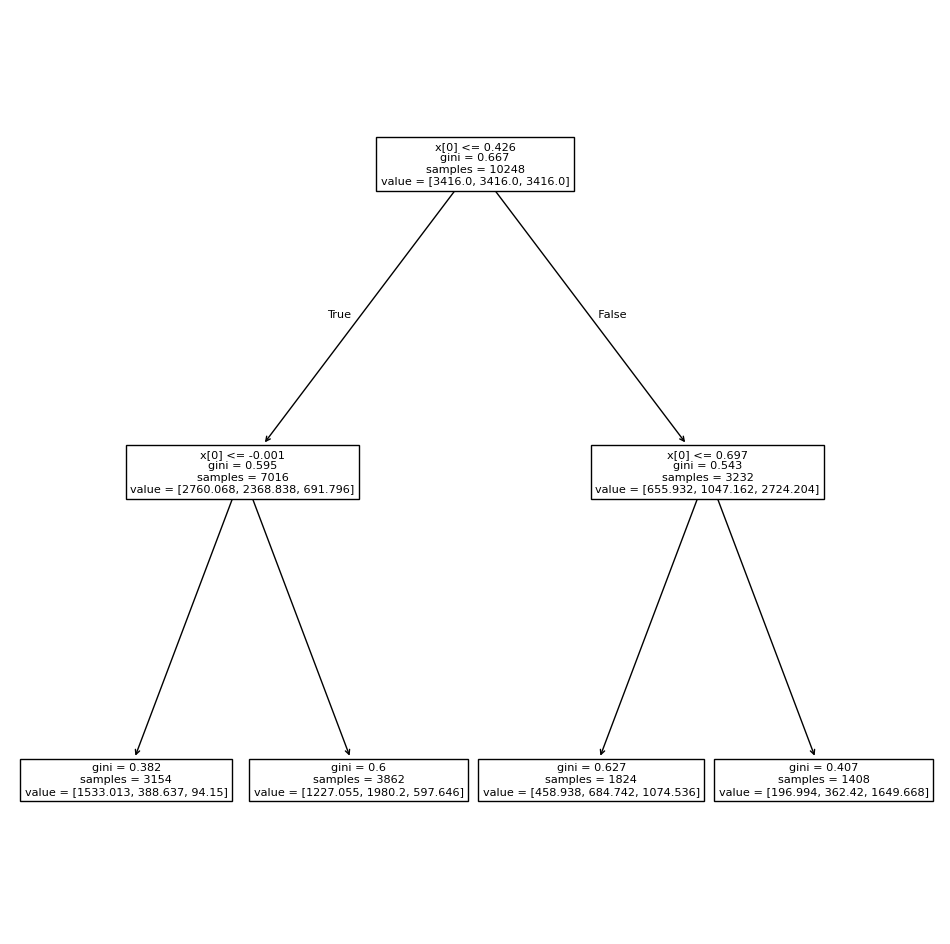

In [64]:
from sklearn import tree
from matplotlib.pyplot import figure
plt.figure(figsize=(12,12))
tmp_figure = tree.plot_tree(clf)
plt.show(tmp_figure)

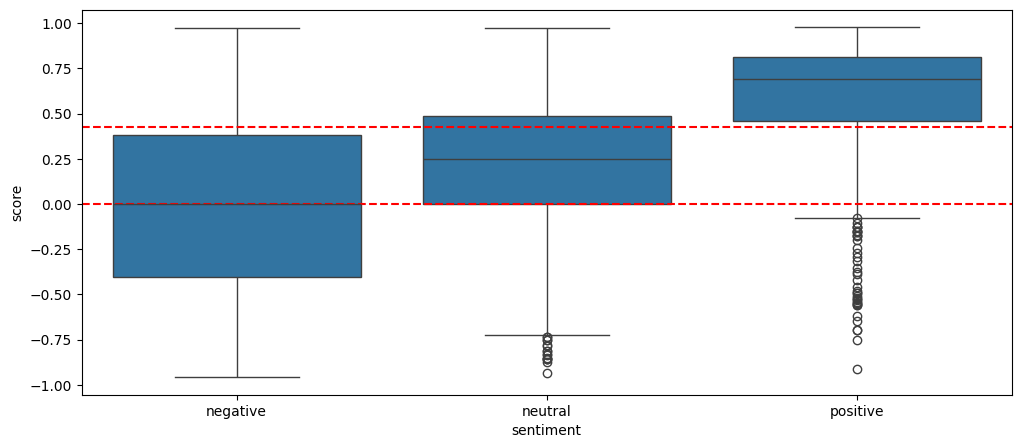

In [65]:

train_sentiment_data = pd.DataFrame({'score': sentiment_score_train, 'sentiment': y_train})
graph = sns.boxplot(x="sentiment", y="score", data=train_sentiment_data, order=["negative", "neutral", "positive"])

graph.axhline(0.426, linestyle= '--',color='red')
graph.axhline(-0.001, linestyle= '--',color='red')

plt.show()
graph.get_figure().savefig('vader_result2.png')

In [66]:
test['sentiment_score'] = sentiment_score_test
test2=test.sort_values("sentiment_score", ascending = False)
test2.loc[(test2["airline_sentiment"]=="negative") & (test2["sentiment_score"]>0.426),:].head(20)

,tweet_id,airline_sentiment,negativereason,airline,text,new_text,corpus,sentiment_score
13794,569715860241129472,negative,Lost Luggage,American,@AmericanAir that luggage you forgot...#mia......,"[luggag, forgot, mia, oscar]",luggag forgot mia oscar,0.9712
13049,569951438329085952,negative,Can't Tell,American,@AmericanAir but don't you worry... @Delta too...,"[worri, took, good, care, loss, gain]",worri took good care loss gain,0.9314
1740,569608866138173440,negative,Bad Flight,United,@United Personal Device Entertainment system i...,"[person, devic, entertain, system, great, app,...",person devic entertain system great app crash ...,0.9300
2348,569249933271965696,negative,Customer Service Issue,United,@united any help is appreciated. That's a LOOO...,"[help, appreci, looong, wait, help, someth, fa...",help appreci looong wait help someth fault,0.9146
3780,568129909408841728,negative,Flight Booking Problems,United,"@united yep, after long waiting on the phone w...","[yep, long, wait, phone, manag, rebook, hope, ...",yep long wait phone manag rebook hope pleasent...,0.9100
3013,568800389903962112,negative,Cancelled Flight,United,@united haha and you have to clean a plane tha...,"[haha, clean, plane, held, overnight, hangar, ...",haha clean plane held overnight hangar sound l...,0.9062
2501,569162600237236224,negative,Flight Booking Problems,United,@United site errored out at last step of chang...,"[site, error, last, step, chang, award, cannot...",site error last step chang award cannot even p...,0.9060
591,570262424038699008,negative,Customer Service Issue,United,"@united I just sent an email to Customer Care,...","[sent, email, custom, care, tell, may, break, ...",sent email custom care tell may break sincer h...,0.9039
4119,567814633047728128,negative,Customer Service Issue,United,"@united thanks for that advice, so helpful. Ca...","[thank, advic, help, cannot, believ, guy, actu...",thank advic help cannot believ guy actual char...,0.9025
2054,569419949007085568,negative,Can't Tell,United,@united nice. I wonder how you pick who to res...,"[nice, wonder, pick, respond, mayb, happi, cus...",nice wonder pick respond mayb happi custom eas...,0.9022


In [67]:
[print(tmp_text) for tmp_text in test2.loc[(test2["airline_sentiment"]=="negative") & (test2["sentiment_score"]>0.426),"text"].head(20)];

@AmericanAir that luggage you forgot...#mia.....he just won an oscar😄💝💝💝
@AmericanAir but don't you worry... @Delta took good care of me... Your loss, their gain.
@United Personal Device Entertainment system is great but with app crashing every 10/15 mins I'm glad it's free for now.
@united any help is appreciated. That's a LOOONG wait for help on something that's not his fault
@united yep, after long waiting on the phone we managed to rebook it. Hope it will be a pleasent one. Thanks for ur help.
@united haha and you have to clean a plane that was held overnight in a hangar. Sounds lovely. Also don't lie on screensand say it's weather
@United site errored out at last step of changing award. Now can't even pull up reservation. 60 minute wait time.  Thanks @United!
@united I just sent an email to Customer Care, telling them I may have to break up with you 😢. I sincerely hope they can help me!!
@united thanks for that advice, so helpful. Can't believe you guys actually charge people to "

In [68]:
i=1740
print(test.loc[i,'text'])
analyzer.polarity_scores(test.loc[i,'text'])

@United Personal Device Entertainment system is great but with app crashing every 10/15 mins I'm glad it's free for now.


{'neg': 0.0, 'neu': 0.503, 'pos': 0.497, 'compound': 0.93}

In [69]:
test2.loc[(test2["airline_sentiment"]=="positive") & (test2["sentiment_score"]<=0),:].tail(20)

,tweet_id,airline_sentiment,negativereason,airline,text,new_text,corpus,sentiment_score
6466,567830740373868544,positive,NaN,Southwest,"Despite Mother Nature's best efforts, @Southwe...","[despit, mother, natur, best, effort, good, hu...",despit mother natur best effort good humor fol...,-0.1945
8030,568854763057475584,positive,NaN,Delta,@JetBlue @AmericanAir ah ha! I misread the end...,"[ah, ha, misread, end, date, thank, clarifi]",ah ha misread end date thank clarifi,-0.2018
9353,569970659297792000,positive,NaN,US Airways,@USAirways look out for flying rocks this time...,"[look, fli, rock, time, bird, plane, nah, neve...",look fli rock time bird plane nah never mind rock,-0.2462
11886,570307312675651585,positive,NaN,American,"@AmericanAir Believe me, I understand. Flight ...","[believ, understand, flight, origin, book, sun...",believ understand flight origin book sunday fl...,-0.2500
5967,568454304488673280,positive,NaN,Southwest,@SouthwestAir ..just booked trip to Cancun...❤...,"[book, trip, cancun, baggag, fee, need, flight...",book trip cancun baggag fee need flight time o...,-0.2960
5937,568470715009277952,positive,NaN,Southwest,@SouthwestAir now flying non stop CMH-OAK has ...,"[fli, non, stop, cmh, oak, daydream, trip, bay...",fli non stop cmh oak daydream trip bay especi ...,-0.2960
5512,568929782286516224,positive,NaN,Southwest,@SouthwestAir I'll have to drop by next time I...,"[drop, next, time, visit]",drop next time visit,-0.3382
6399,567880908528832513,positive,NaN,Southwest,@SouthwestAir can't wait! Thanks for the respo...,"[cannot, wait, thank, respons]",cannot wait thank respons,-0.4570
6298,568076081665679360,positive,NaN,Southwest,@SouthwestAir OH MY GOSH SERIOUSLY?! you just ...,"[oh, gosh, serious, made, day, week, year, one...",oh gosh serious made day week year one appreci,-0.4768
10835,568834902365503488,positive,NaN,US Airways,@USAirways i got through and am able to switch...,"[got, abl, switch, flight, charg, thank]",got abl switch flight charg thank,-0.5122


In [70]:
i=4614
print(test.loc[i,'text'])
analyzer.polarity_scores(test.loc[i,'text'])

@SouthwestAir What can we do to bring you back to Jackson, MS?! We miss you terribly around here. These other airlines are horrible!!


{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'compound': -0.8617}

In [71]:
from sklearn.preprocessing import Binarizer
freq = CountVectorizer(binary=False)
corpus_count_train = freq.fit_transform(train.loc[:, 'corpus'])
corpus_count_test = freq.transform(test.loc[:, 'corpus'])


onehot = Binarizer()
corpus_onehot_train = onehot.fit_transform(corpus_count_train.toarray())
corpus_onehot_test = onehot.fit_transform(corpus_count_test.toarray())


data_count_train = pd.DataFrame(corpus_count_train.toarray(), columns = freq.get_feature_names_out())
data_count_test = pd.DataFrame(corpus_count_test.toarray(), columns = freq.get_feature_names_out())


data_onehot_train = pd.DataFrame(corpus_onehot_train, columns = freq.get_feature_names_out())
data_onehot_test = pd.DataFrame(corpus_onehot_test, columns = freq.get_feature_names_out())



In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
corpus_tfidf_train = tfidf.fit_transform(train.loc[:, 'corpus'])
corpus_tfidf_test = tfidf.transform(test.loc[:, 'corpus'])


data_tfidf_train = pd.DataFrame(corpus_tfidf_train.toarray(), columns = tfidf.get_feature_names_out())
data_tfidf_test = pd.DataFrame(corpus_tfidf_test.toarray(), columns = tfidf.get_feature_names_out())

In [73]:
# print(train.iloc[5:7,:].text)
# train.iloc[5:7,:].new_text.to_csv("tmp.csv")

# tmp = data_onehot_train.iloc[5:7,:]
# tmp = tmp.loc[:,tmp.sum(axis=0)!=0]
# tmp.to_csv("tmp2.csv")

## Logistic Regression

[[2199  452  163]
 [ 182  602  100]
 [  77  100  517]]
              precision    recall  f1-score   support

    negative       0.78      0.89      0.83      2458
     neutral       0.68      0.52      0.59      1154
    positive       0.74      0.66      0.70       780

    accuracy                           0.76      4392
   macro avg       0.74      0.69      0.71      4392
weighted avg       0.75      0.76      0.75      4392



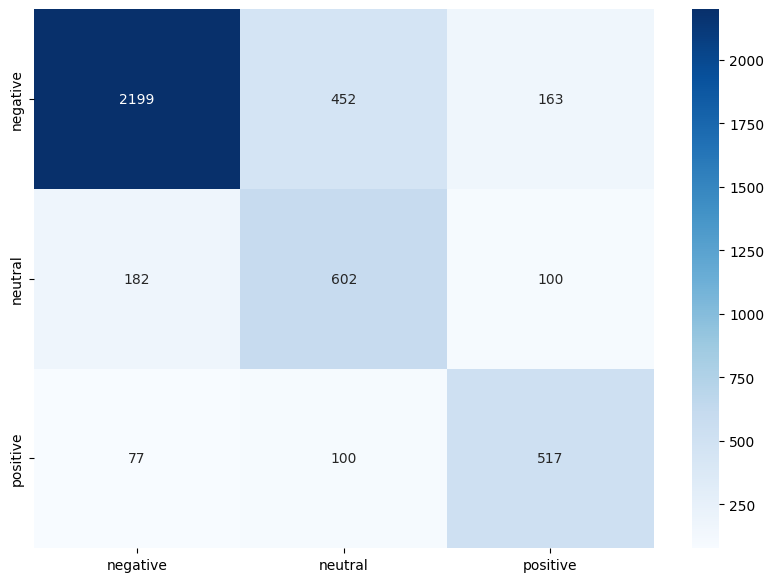

In [74]:
from sklearn.linear_model import LogisticRegression

clf_l1 = LogisticRegression(class_weight="balanced")
clf_l1 = clf_l1.fit(data_onehot_train, y_train)

y_test_predict = clf_l1.predict(data_onehot_test)


df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_onehot.png')


print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

[[2205  446  163]
 [ 181  600  103]
 [  70  103  521]]
              precision    recall  f1-score   support

    negative       0.78      0.90      0.84      2456
     neutral       0.68      0.52      0.59      1149
    positive       0.75      0.66      0.70       787

    accuracy                           0.76      4392
   macro avg       0.74      0.69      0.71      4392
weighted avg       0.75      0.76      0.75      4392



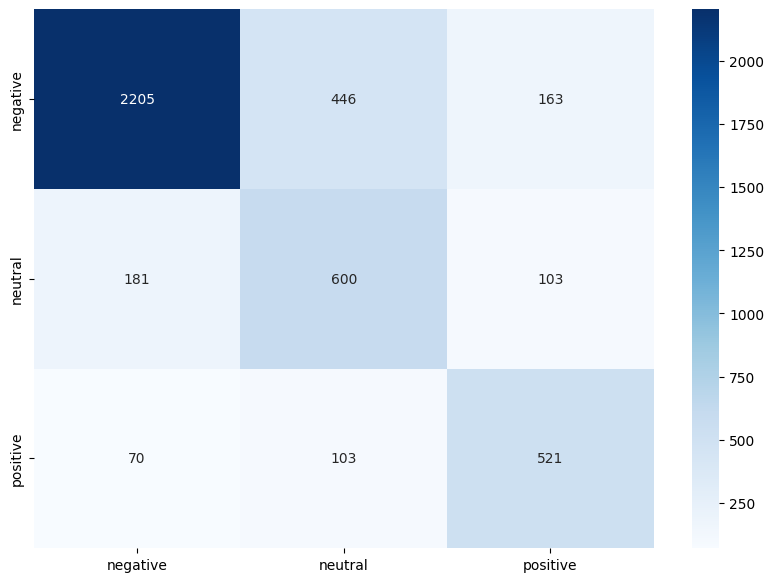

In [75]:
clf_l2 = LogisticRegression(class_weight="balanced")
clf_l2 = clf_l2.fit(data_count_train, y_train)

y_test_predict = clf_l2.predict(data_count_test)


df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_onehot.png')


print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

[[2225  432  157]
 [ 197  594   93]
 [  73  113  508]]
              precision    recall  f1-score   support

    negative       0.79      0.89      0.84      2495
     neutral       0.67      0.52      0.59      1139
    positive       0.73      0.67      0.70       758

    accuracy                           0.76      4392
   macro avg       0.73      0.69      0.71      4392
weighted avg       0.75      0.76      0.75      4392



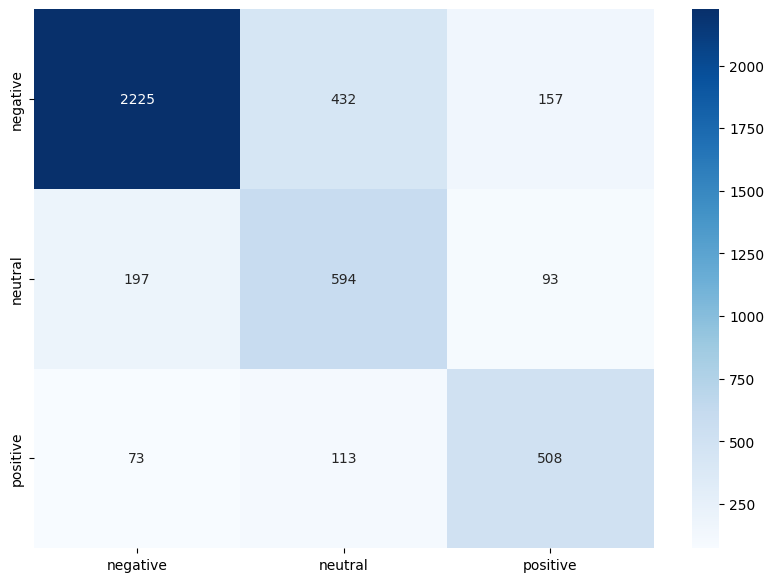

In [76]:
clf_l3 = LogisticRegression(class_weight="balanced")
clf_l3 = clf_l3.fit(data_tfidf_train, y_train)

y_test_predict = clf_l3.predict(data_tfidf_test)


df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_onehot.png')


print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

## Decision Tree

[[2158  426  230]
 [ 323  433  128]
 [ 155  101  438]]
              precision    recall  f1-score   support

    negative       0.77      0.82      0.79      2636
     neutral       0.49      0.45      0.47       960
    positive       0.63      0.55      0.59       796

    accuracy                           0.69      4392
   macro avg       0.63      0.61      0.62      4392
weighted avg       0.68      0.69      0.68      4392



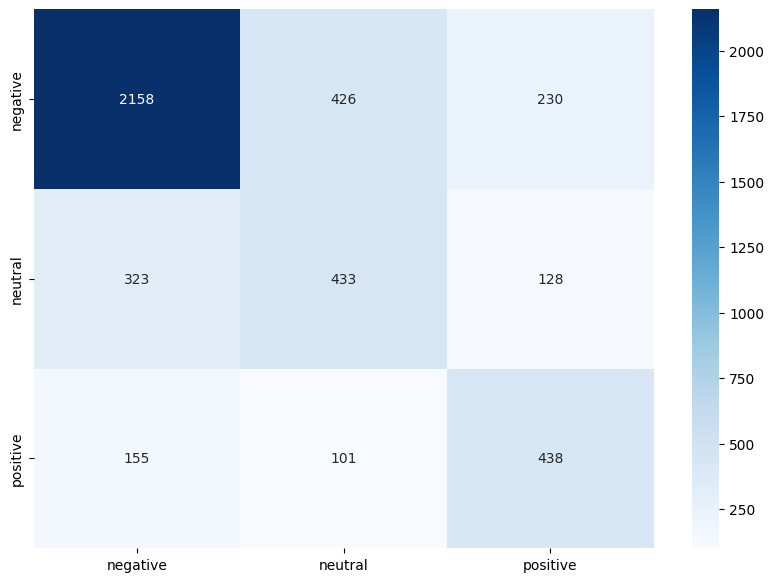

In [77]:
clf1 = DecisionTreeClassifier(class_weight="balanced")
clf1 = clf1.fit(data_onehot_train, y_train)

y_test_predict = clf1.predict(data_onehot_test)


df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_onehot.png')


print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

[[2119  448  247]
 [ 293  467  124]
 [ 140  113  441]]
              precision    recall  f1-score   support

    negative       0.75      0.83      0.79      2552
     neutral       0.53      0.45      0.49      1028
    positive       0.64      0.54      0.59       812

    accuracy                           0.69      4392
   macro avg       0.64      0.61      0.62      4392
weighted avg       0.68      0.69      0.68      4392



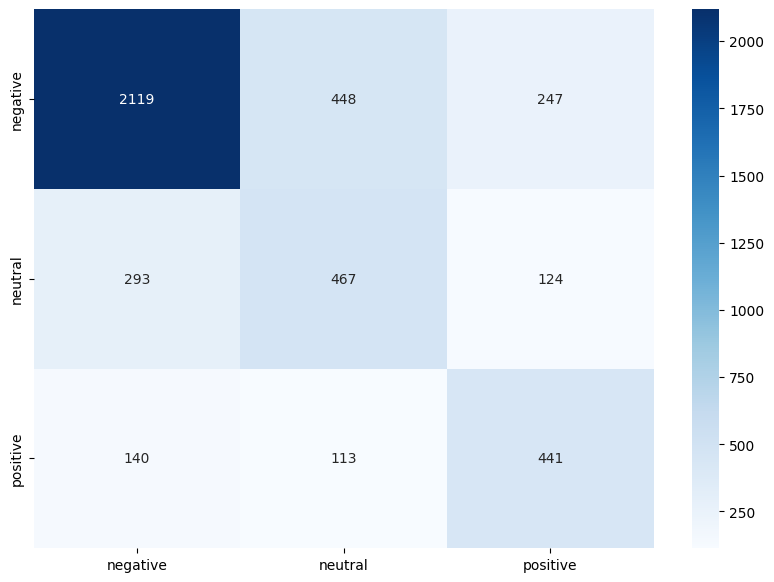

In [78]:
clf2 = DecisionTreeClassifier(class_weight="balanced")
clf2 = clf2.fit(data_count_train, y_train)

y_test_predict = clf2.predict(data_count_test)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_count.png')


print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

[[2133  420  261]
 [ 328  444  112]
 [ 165  112  417]]
              precision    recall  f1-score   support

    negative       0.76      0.81      0.78      2626
     neutral       0.50      0.45      0.48       976
    positive       0.60      0.53      0.56       790

    accuracy                           0.68      4392
   macro avg       0.62      0.60      0.61      4392
weighted avg       0.67      0.68      0.68      4392



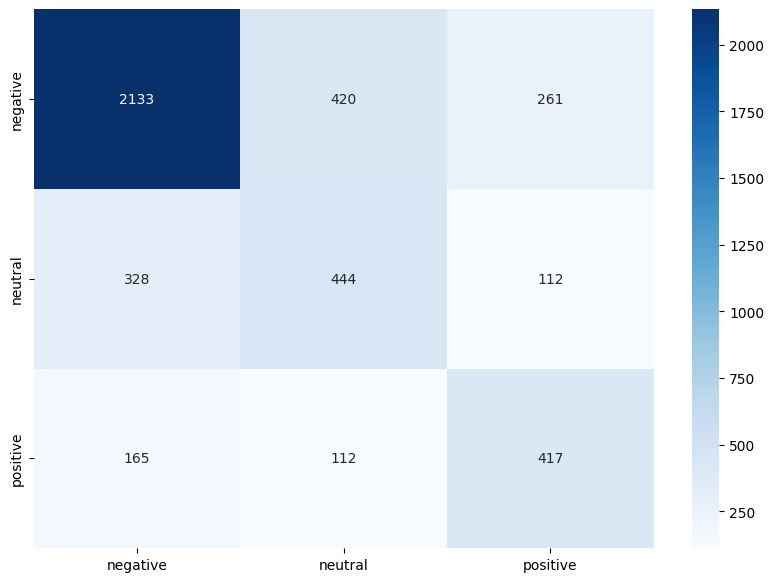

In [79]:
clf3 = DecisionTreeClassifier(class_weight="balanced")
clf3 = clf3.fit(data_tfidf_train, y_train)

y_test_predict = clf3.predict(data_tfidf_test)


df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_decision_tfidf.png')

print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

## Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

              precision    recall  f1-score   support

    negative       0.88      0.83      0.85      2984
     neutral       0.52      0.57      0.54       794
    positive       0.64      0.73      0.68       614

    accuracy                           0.77      4392
   macro avg       0.68      0.71      0.69      4392
weighted avg       0.78      0.77      0.77      4392



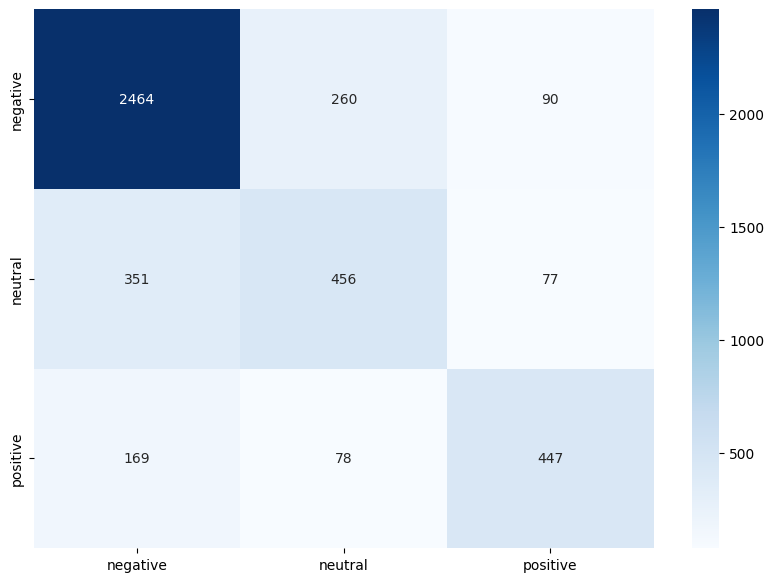

In [81]:
clf_r1 = RandomForestClassifier(n_estimators=500,class_weight="balanced")
clf_r1 = clf_r1.fit(data_onehot_train, y_train)

y_test_predict = clf_r1.predict(data_onehot_test)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_RF_onehot.png')

confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"])
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

Text(0.5, 0, 'Random Forest Feature Importance')

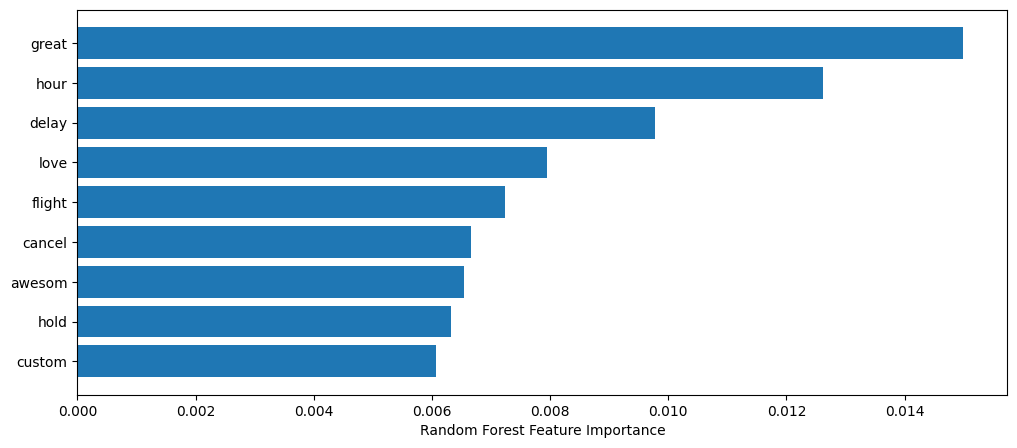

In [82]:
sorted_idx = clf_r1.feature_importances_.argsort()
plt.barh(data_onehot_train.columns[sorted_idx][-10:-1], clf_r1.feature_importances_[sorted_idx][-10:-1])
plt.xlabel("Random Forest Feature Importance")

In [83]:
train.loc[['understand' in tmp_text for tmp_text in train['new_text']],:]

,tweet_id,airline_sentiment,negativereason,airline,text,new_text,corpus
1506,569693820398510080,negative,Can't Tell,United,@united I understand the intent was not to inc...,"[understand, intent, inconveni, catch, cab, ba...",understand intent inconveni catch cab back air...
9423,569943090766721024,neutral,NaN,US Airways,@USAirways US 728 stated their issues as: kept...,"[us, state, issu, kept, plane, ground, allow, ...",us state issu kept plane ground allow connect ...
7259,569722876879884288,neutral,NaN,Delta,@JetBlue I understand delays. We are all look...,"[understand, delay, look, tv, monitor, ur, gat...",understand delay look tv monitor ur gate say c...
9862,569633357451153408,negative,Flight Booking Problems,US Airways,@usairways I don't understand why I can't get ...,"[understand, cannot, get, miss, mile, flight, ...",understand cannot get miss mile flight dividen...
3688,568186047659507712,neutral,NaN,United,"@united, Understandable. I did try Flight Book...","[understand, tri, flight, book, problem, sever...",understand tri flight book problem sever time ...
...,...,...,...,...,...,...,...
512,570302375510056960,neutral,NaN,United,"@united I understand, but it's tough when ther...","[understand, tough, way, get, airport, w, seri...",understand tough way get airport w serious ris...
6616,567756556536909825,negative,Late Flight,Southwest,@SouthwestAir I understand a delay but to be s...,"[understand, delay, stuck, plane, longer, flig...",understand delay stuck plane longer flight una...
14571,569597742693154816,negative,Customer Service Issue,American,@AmericanAir I understand weather is not your ...,"[understand, weather, fault, ur, cs, rep, atro...",understand weather fault ur cs rep atroci happ...
12743,570040750412406784,positive,NaN,American,@AmericanAir the folks at the Executive Platin...,"[folk, execut, platinum, desk, great, pros, un...",folk execut platinum desk great pros understan...


              precision    recall  f1-score   support

    negative       0.88      0.83      0.85      2989
     neutral       0.51      0.58      0.54       788
    positive       0.64      0.73      0.68       615

    accuracy                           0.77      4392
   macro avg       0.68      0.71      0.69      4392
weighted avg       0.78      0.77      0.77      4392



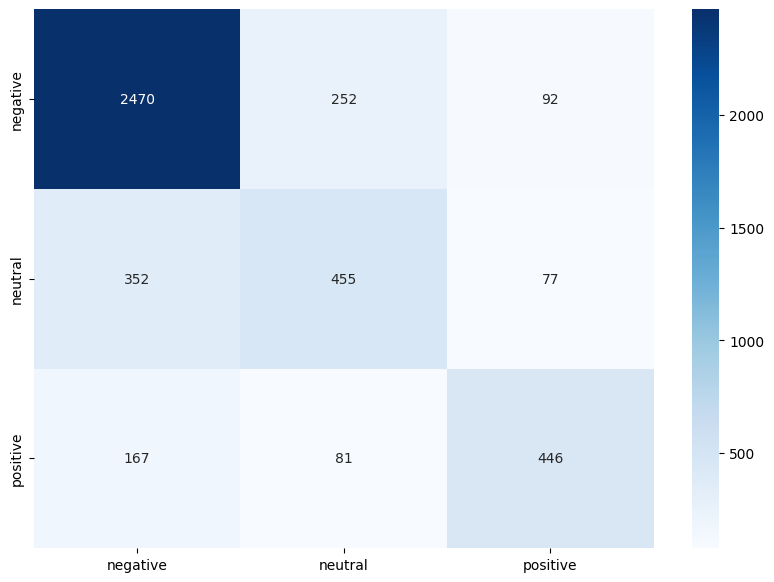

In [84]:
clf_r2 = RandomForestClassifier(n_estimators=500,class_weight="balanced")
clf_r2 = clf_r2.fit(data_count_train, y_train)

y_test_predict = clf_r2.predict(data_count_test)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_RF_count.png')

confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"])
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

Text(0.5, 0, 'Random Forest Feature Importance')

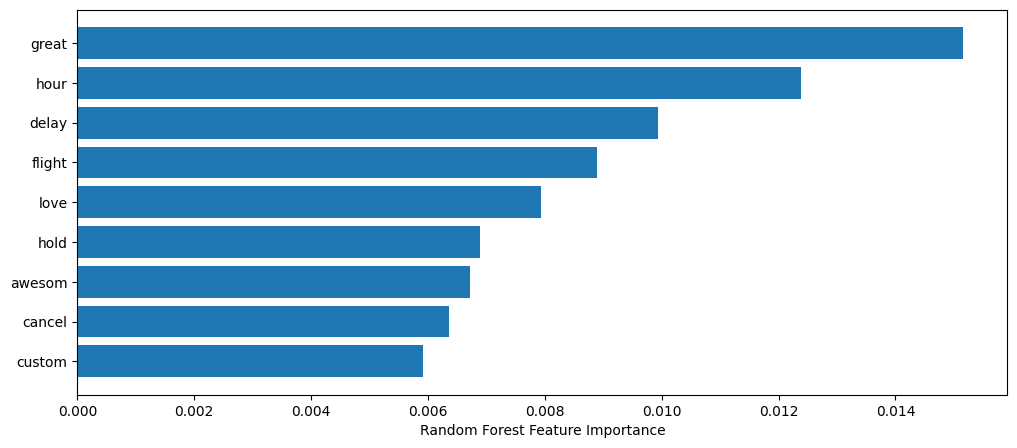

In [85]:
sorted_idx = clf_r2.feature_importances_.argsort()
plt.barh(data_count_train.columns[sorted_idx][-10:-1], clf_r2.feature_importances_[sorted_idx][-10:-1])
plt.xlabel("Random Forest Feature Importance")

[[2537  214   63]
 [ 378  447   59]
 [ 193   75  426]]
              precision    recall  f1-score   support

    negative       0.90      0.82      0.86      3108
     neutral       0.51      0.61      0.55       736
    positive       0.61      0.78      0.69       548

    accuracy                           0.78      4392
   macro avg       0.67      0.73      0.70      4392
weighted avg       0.80      0.78      0.78      4392



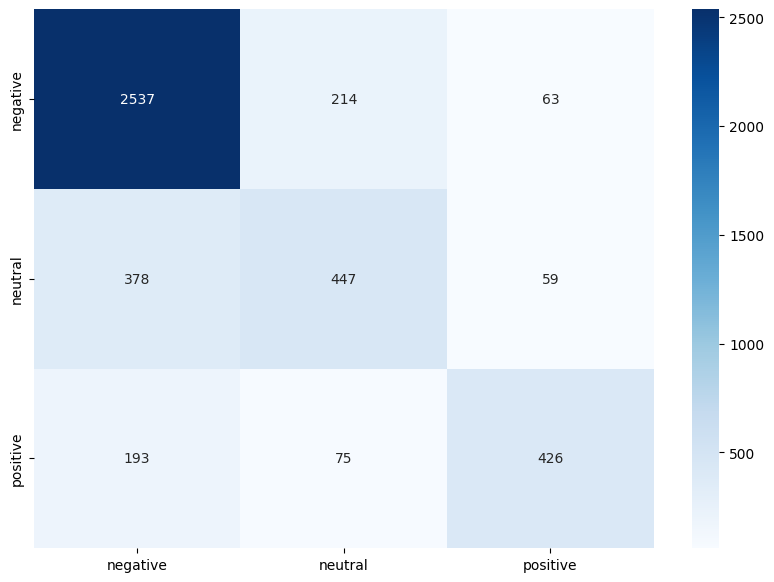

In [86]:
clf_r3 = RandomForestClassifier(n_estimators=500,class_weight="balanced")
clf_r3 = clf_r3.fit(data_tfidf_train, y_train)

y_test_predict = clf_r3.predict(data_tfidf_test)

df_cm = pd.DataFrame(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_RF_tfidf.png')

print(confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"]))
accuracy_score(y_test_predict,y_test)
print(classification_report(y_test_predict,y_test))

Text(0.5, 0, 'Random Forest Feature Importance')

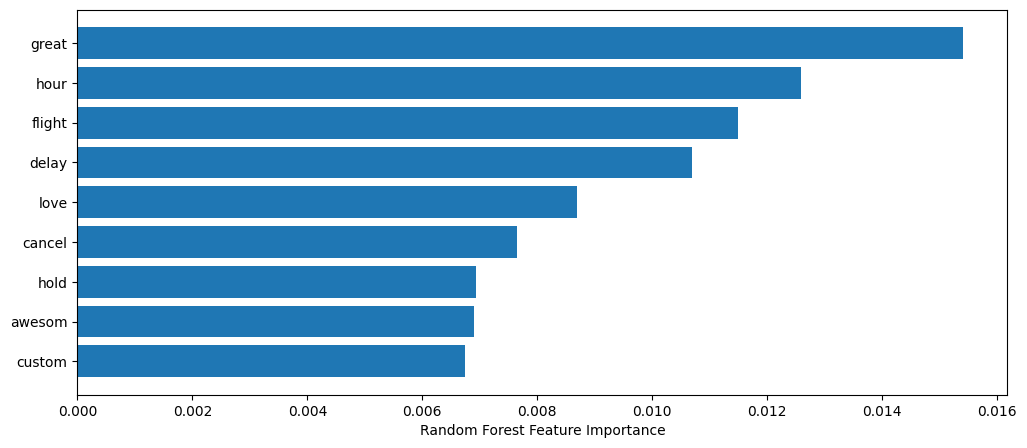

In [87]:
sorted_idx = clf_r3.feature_importances_.argsort()
plt.barh(data_tfidf_train.columns[sorted_idx][-10:-1], clf_r3.feature_importances_[sorted_idx][-10:-1])
plt.xlabel("Random Forest Feature Importance")

In [91]:
confusion_matrix(y_test, y_test_predict, labels=["negative", "neutral", "positive"])

array([[2537,  214,   63],
       [ 378,  447,   59],
       [ 193,   75,  426]])

## LSTM

In [93]:
def sentiment2(x):
    if x == 'positive':
        return 2
    elif x == 'negative':
        return 0
    else:
        return 1

In [94]:
train["sentiment"]=[sentiment2(tmp_sentiemnt) for tmp_sentiemnt in train["airline_sentiment"]]

test["sentiment"]=[sentiment2(tmp_sentiemnt) for tmp_sentiemnt in test["airline_sentiment"]]

In [95]:
from torch.utils.data import TensorDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [96]:
class Sequences(Dataset):
    def __init__(self, texts_train, texts_test, max_seq_len):
        self.max_seq_len = max_seq_len

        texts = np.concatenate((texts_train,texts_test))

        # BOW
        vectorizer = CountVectorizer(stop_words='english', min_df=0.0001)
        vectorizer.fit(texts.tolist())

        # Creating Vocabulary
        self.token2idx = vectorizer.vocabulary_

        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1

        tokenizer = vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx]
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]

        sequences_train = [self.encode(sequence)[:max_seq_len] for sequence in texts_train.tolist()]

        self.sequences_train = [self.pad(sequence) for sequence in sequences_train]

        sequences_test = [self.encode(sequence)[:max_seq_len] for sequence in texts_test.tolist()]

        self.sequences_test = [self.pad(sequence) for sequence in sequences_test]


    # def __len__(self):
    #     return len(self.sequences)

In [97]:
input_seq = Sequences(train.text.values, test.text.values, max_seq_len=128)


In [98]:
labels_train = torch.tensor(train.sentiment.values)
labels_test = torch.tensor(test.sentiment.values)

input_train = torch.tensor(input_seq.sequences_train)
input_test = torch.tensor(input_seq.sequences_test)

data_train = TensorDataset(input_train, labels_train)
data_test = TensorDataset(input_test, labels_test)

In [99]:
possible_label = train.airline_sentiment.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

{'neutral': 0, 'negative': 1, 'positive': 2}

In [100]:
class LSTMNet(nn.Module):

    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,bidirectional,dropout):

        super(LSTMNet,self).__init__()

        # Embedding layer converts integer sequences to vector sequences
        self.embedding = nn.Embedding(vocab_size,embedding_dim)

        # LSTM layer process the vector sequences
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )

        # Dense layer to predict
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        # Prediction activation function
        self.sigmoid = nn.Sigmoid()


    def forward(self,text):
        embedded = self.embedding(text)

        # Thanks to packing, LSTM don't see padding tokens
        # and this makes our model better
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True)
        # packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)

        packed_output,(hidden_state,cell_state) = self.lstm(embedded)

        # Concatenating the final forward and backward hidden states
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)

        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.sigmoid(dense_outputs)


        return outputs

In [101]:
SIZE_OF_VOCAB = len(input_seq.token2idx)
print(SIZE_OF_VOCAB)
EMBEDDING_DIM = 300
NUM_HIDDEN_NODES = 128
NUM_OUTPUT_NODES = 3
NUM_LAYERS = 4
BIDIRECTION = True
DROPOUT = 0.1

6145


In [102]:
#from transformers import BertForSequenceClassification
model = LSTMNet(SIZE_OF_VOCAB,
                EMBEDDING_DIM,
                NUM_HIDDEN_NODES,
                NUM_OUTPUT_NODES,
                NUM_LAYERS,
                BIDIRECTION,
                DROPOUT)

In [103]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16

)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32

)

In [104]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-3,eps = 1e-8, weight_decay = 0.001)

epochs  = 20
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [105]:
from sklearn.metrics import f1_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

In [106]:
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}

    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [107]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [108]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cpu


In [109]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "text":batch[0],

        }
        with torch.no_grad():
            output = model(**inputs)

        target = batch[1]


        output = model(**inputs)

        loss = criterion(output, target)

        #loss = outputs[0]
        logits = output
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = target.cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [110]:
from tqdm.notebook import tqdm

In [111]:
from sklearn.utils.class_weight import compute_class_weight
tmp_weight = compute_class_weight(class_weight='balanced',classes = np.unique(train["sentiment"]), y = np.array(train["sentiment"]))
tmp_weight = torch.tensor(tmp_weight, dtype=torch.float)

# Move class weights to the same device as the model
tmp_weight = tmp_weight.to(device)
criterion = torch.nn.CrossEntropyLoss(weight=tmp_weight)

In [112]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "text":batch[0]

        }

        target = batch[1]


        output = model(**inputs)

        loss = criterion(output, target)
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/kaggle/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch

    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.9418408367637539


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8796453773975372
 Test Score:0.6872048425117567


Epoch: 2:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.8419161039098004


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8668325258337933
 Test Score:0.7230695920138961


Epoch: 3:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.7943096625823498


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8558373628319174
 Test Score:0.7349286755764569


Epoch: 4:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.7554311355264994


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8576518465643344
 Test Score:0.7338247906659298


Epoch: 5:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.7386676792793453


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8382909535497859
 Test Score:0.7450182880261803


Epoch: 6:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.7204846794631291


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8424613048201022
 Test Score:0.746681394736409


Epoch: 7:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.7078430668426192


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8411702600078307
 Test Score:0.7517920661112371


Epoch: 8:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.698995415673427


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8354192328625831
 Test Score:0.7496112348747703


Epoch: 9:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.691177704776877


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8493659902310026
 Test Score:0.7520702779506845


Epoch: 10:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6809934874220683


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8460237565247909
 Test Score:0.7442131007779317


Epoch: 11:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6774581256039243


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.852856879648955
 Test Score:0.7553165051916084


Epoch: 12:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6749593213828231


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8385956317618273
 Test Score:0.7591712631996088


Epoch: 13:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6720215643809849


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8579092777293661
 Test Score:0.756835373702328


Epoch: 14:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6710585390163845


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8511412545390751
 Test Score:0.7559065204192005


Epoch: 15:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6713387040935701


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8480776643407517
 Test Score:0.756939907756541


Epoch: 16:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6702585457453676


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.854087327701458
 Test Score:0.7590681343401176


Epoch: 17:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6676667785495752


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8607849573743516
 Test Score:0.758742963247565


Epoch: 18:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6656582264372042


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8494649564010509
 Test Score:0.7585108409875945


Epoch: 19:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6654997777641285


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8531656196151954
 Test Score:0.761662362722147


Epoch: 20:   0%|          | 0/641 [00:00<?, ?it/s]

<ipython-input-112-362149f01f87>:29: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(),1.0)



Epoch {epoch}
Training Loss: 0.6652822124418714


  0%|          | 0/138 [00:00<?, ?it/s]

Val Loss:0.8533020680365355
 Test Score:0.7613742116328738


In [113]:
torch.save(model.state_dict(),f'./LSTM_ft_final.model')

RuntimeError: Parent directory /kaggle/output does not exist.

In [ ]:
model.to(device)

In [ ]:
_,predictions,true_vals = evaluate(dataloader_test)

In [ ]:
preds_flat = np.argmax(predictions,axis=1).flatten()
labels_flat = true_vals.flatten()

In [ ]:
labels_flat

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
print(confusion_matrix(labels_flat, preds_flat, labels=[0,1,2]))


df_cm = pd.DataFrame(confusion_matrix(labels_flat, preds_flat, labels=[0,1,2]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_LSTM.png')

accuracy_score(preds_flat,labels_flat)
print(classification_report(preds_flat,labels_flat))

## Bert Model

In [ ]:
def sentiment2(x):
    if x == 'positive':
        return 2
    elif x == 'negative':
        return 0
    else:
        return 1

In [ ]:
train["sentiment"]=[sentiment2(tmp_sentiemnt) for tmp_sentiemnt in train["airline_sentiment"]]

test["sentiment"]=[sentiment2(tmp_sentiemnt) for tmp_sentiemnt in test["airline_sentiment"]]

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import torch

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [ ]:
encoder_train = tokenizer.batch_encode_plus(train.text.values,
                                           add_special_tokens = True,
                                           #return_attention_masks = True,
                                           pad_to_max_length = True,
                                           #max_length = 256,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(test.text.values,
                                           add_special_tokens = True,
                                           #return_attention_masks = True,
                                           pad_to_max_length = True,
                                           #max_length = 256,
                                           return_tensors = 'pt')


input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(train.sentiment.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(test.sentiment.values)

In [ ]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [ ]:
possible_label = train.airline_sentiment.unique()
dict_label = {}
for index,possible_label in enumerate(possible_label):
    dict_label[possible_label] = index
dict_label

In [ ]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                     num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

In [ ]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16

)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32

)

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 20
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs
)

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')

In [ ]:
def accuracy_per_class(preds,labels):
    label_dict_reverse = {v:k for k,v in dict_label.items()}

    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Class:{label_dict_reverse}")
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

In [ ]:
def evaluate(dataloader_val):
    model.eval()

    loss_val_total = 0
    predictions,true_vals = [],[]

    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)


    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()

    loss_train_total=0

    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)


    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]

        }
        outputs = model(**inputs)

        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)

        optimizer.step()
        scheduler.step()


        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/kaggle/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch

    tqdm.write('\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')

In [ ]:
torch.save(model.state_dict(),f'./BERT_ft_final.model')

In [ ]:
model.to(device)

In [ ]:
_,predictions,true_vals = evaluate(dataloader_test)

In [ ]:
preds_flat = np.argmax(predictions,axis=1).flatten()
labels_flat = true_vals.flatten()

In [ ]:
labels_flat

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
print(confusion_matrix(labels_flat, preds_flat, labels=[0,1,2]))


df_cm = pd.DataFrame(confusion_matrix(labels_flat, preds_flat, labels=[0,1,2]),
                     index = ["negative", "neutral", "positive"],
                  columns = ["negative", "neutral", "positive"])
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

ax.get_figure().savefig('confusion_Bert.png')

accuracy_score(preds_flat,labels_flat)
print(classification_report(preds_flat,labels_flat))